In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import display

# Example format of your dataset
# annotations = [
#     {'image_id': 'image1.jpg', 'label': 'cat', 'bbox': [50, 60, 150, 200]},  # [x_min, y_min, x_max, y_max]
#     {'image_id': 'image1.jpg', 'label': 'dog', 'bbox': [120, 130, 300, 400]},
#     {'image_id': 'image2.jpg', 'label': 'cat', 'bbox': [30, 50, 100, 180]},
#     ...
# ]

train_data = pd.read_csv("train_validate/TrainDataset.csv")
test_data = pd.read_csv("train_validate/TestDataset.csv")

data = pd.concat([train_data, test_data], ignore_index=True)
data.sample(5)

,Image_ID,class,confidence,ymin,xmin,ymax,xmax
9330,id_43cevf8y4e.jpg,Trophozoite,1.0,2878,1358,2964,1450
6860,id_gjxj3qaqpl.jpg,WBC,1.0,961,793,1035,852
11446,id_1760ihasgs.jpg,Trophozoite,1.0,953,1050,993,1103
15079,id_1xpbtfb4xh.jpg,Trophozoite,1.0,541,902,573,932
9754,id_1roo39ojs0.jpg,WBC,1.0,131,1440,209,1519


In [2]:
data["Image_ID"].nunique(), data["class"].nunique()

(2747, 3)

In [3]:
data["class"].value_counts()

class
Trophozoite    15838
WBC             7004
NEG              688
Name: count, dtype: int64

In [4]:
data_stats = data.groupby("Image_ID")["class"].value_counts().reset_index().pivot_table(
    index="Image_ID", columns="class", fill_value=0
)
data_stats.describe()

count                          
class          NEG  Trophozoite          WBC
count  2747.000000  2747.000000  2747.000000
mean      0.250455     5.765562     2.549691
std       0.433354     8.703019     3.816721
min       0.000000     0.000000     0.000000
25%       0.000000     0.000000     0.000000
50%       0.000000     3.000000     1.000000
75%       1.000000     7.000000     4.000000
max       1.000000    82.000000    42.000000

In [5]:
data_stats.sum()

       class      
count  NEG              688.0
       Trophozoite    15838.0
       WBC             7004.0
dtype: float64

In [6]:
data_stats.sum(axis=1).describe()

count    2747.000000
mean        8.565708
std        10.206229
min         1.000000
25%         1.000000
50%         5.000000
75%        11.000000
max        92.000000
dtype: float64

In [7]:
data.sample(5)

,Image_ID,class,confidence,ymin,xmin,ymax,xmax
8477,id_r7rcvu1zc8.jpg,Trophozoite,1.0,74,1003,114,1041
20224,id_9qtfjptkch.jpg,Trophozoite,1.0,1839,2029,2008,2135
1268,id_s91hx9uyin.jpg,Trophozoite,1.0,643,480,671,516
7120,id_stx1sghla9.jpg,Trophozoite,1.0,293,2450,360,2520
22096,id_wij48tbsif.jpg,Trophozoite,1.0,514,2298,611,2374


In [8]:
annotations = data[data["class"] != "NEG"].apply(
    lambda x: {
        "image_id": x["Image_ID"],
        "label": x["class"],
        "bbox": [x["xmin"], x["ymin"], x["xmax"], x["ymax"]],
    }, axis=1
).tolist()

len(annotations)

22842

In [9]:
annotations[:5]

[{'image_id': 'id_u3q6jdck4j.jpg',
  'label': 'Trophozoite',
  'bbox': [1241, 712, 1270, 737]},
 {'image_id': 'id_a6cl90trri.jpg',
  'label': 'Trophozoite',
  'bbox': [1566, 558, 1604, 600]},
 {'image_id': 'id_qvc2le9sm8.jpg',
  'label': 'Trophozoite',
  'bbox': [2788, 1317, 2914, 1448]},
 {'image_id': 'id_i7r9hkhxvx.jpg',
  'label': 'WBC',
  'bbox': [906, 846, 963, 903]},
 {'image_id': 'id_fzogq9kijh.jpg',
  'label': 'WBC',
  'bbox': [280, 641, 373, 711]}]

In [10]:
def compute_area(bbox):
    """Calculate area of the bounding box."""
    x_min, y_min, x_max, y_max = bbox
    return (x_max - x_min) * (y_max - y_min)

def compute_aspect_ratio(bbox):
    """Calculate aspect ratio of the bounding box."""
    x_min, y_min, x_max, y_max = bbox
    width = x_max - x_min
    height = y_max - y_min
    return width / height if height != 0 else 0

def explore_object_detection_data(annotations):
    """Explore object detection data for insights."""
    label_stats = defaultdict(lambda: {'areas': [], 'aspect_ratios': []})
    image_stats = defaultdict(list)

    # Gather statistics for each label and image
    for ann in annotations:
        label = ann['label']
        bbox = ann['bbox']
        area = compute_area(bbox)
        aspect_ratio = compute_aspect_ratio(bbox)

        # Accumulate label statistics
        label_stats[label]['areas'].append(area)
        label_stats[label]['aspect_ratios'].append(aspect_ratio)

        # Accumulate per image stats
        image_stats[ann['image_id']].append(area)

    # Calculate statistics per label
    label_summary = {}
    for label, stats in label_stats.items():
        avg_area = np.mean(stats['areas'])
        avg_aspect_ratio = np.mean(stats['aspect_ratios'])
        label_summary[label] = {
            'avg_area': avg_area,
            'avg_aspect_ratio': avg_aspect_ratio,
            'num_instances': len(stats['areas']),
            'total_area_coverage': np.sum(stats['areas'])
        }

    # Calculate overall statistics
    overall_avg_area = np.mean([area for stats in label_stats.values() for area in stats['areas']])
    overall_avg_aspect_ratio = np.mean([ratio for stats in label_stats.values() for ratio in stats['aspect_ratios']])

    # Convert to DataFrame for better visualization
    label_df = pd.DataFrame.from_dict(label_summary, orient='index')
    label_df.sort_values(by='num_instances', ascending=False, inplace=True)

    print("Label Summary:")
    display(label_df)

    print(f"\nOverall average area: {overall_avg_area}")
    print(f"Overall average aspect ratio: {overall_avg_aspect_ratio}")

    # Plotting statistics
    label_df['avg_area'].plot(kind='bar', title='Average Bounding Box Area per Label')
    plt.ylabel('Average Area')
    plt.show()

    label_df['num_instances'].plot(kind='bar', title='Number of Instances per Label')
    plt.ylabel('Instance Count')
    plt.show()

    label_df['avg_aspect_ratio'].plot(kind='bar', title='Average Aspect Ratio per Label')
    plt.ylabel('Aspect Ratio')
    plt.show()

    return label_df

# Example usage:
# annotations = load_annotations()  # Load your dataset annotations here
# label_summary_df = explore_object_detection_data(annotations)


Label Summary:


,avg_area,avg_aspect_ratio,num_instances,total_area_coverage
Trophozoite,5392.149135,0.996745,15838,85400858
WBC,15429.718447,1.011628,7004,108069748



Overall average area: 8469.95035460993
Overall average aspect ratio: 1.0013083799037314


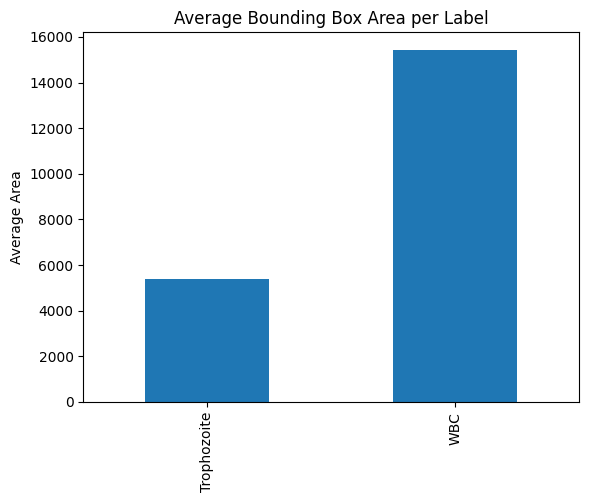

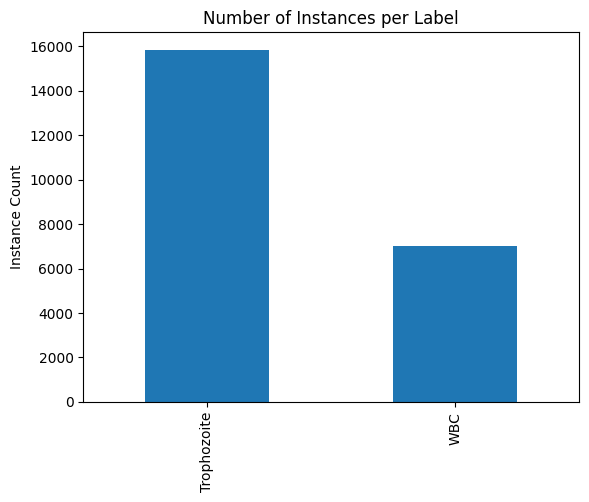

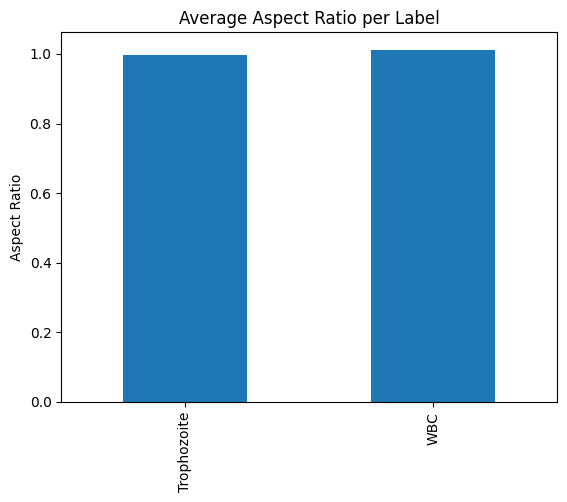

In [11]:
label_summary_df = explore_object_detection_data(annotations)

In [1]:
import os


os.environ["WANDB_PROJECT"] = "lacuna_zindi_challenge"
# os.environ["WANDB_LOG_MODEL"] = "true"
os.environ["WANDB_WATCH"] = "none"
os.environ["WANDB_NOTEBOOK_NAME"] = "train_hf"

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from zindi_code import MODEL_NAME, TRAIN_CSV, VAL_CSV, CLS_MAPPER
from zindi_code.dataset import (
    collate_fn,
    load_dataset,
    transform_aug_ann,
)
from zindi_code.transforms import IMAGE_PROCESSOR
from zindi_code.metrics import compute_metrics


# from zindi_code.hf_alex.model import DetrForObjectDetection

train_set = load_dataset(TRAIN_CSV, nan_frac=0).with_transform(transform_aug_ann)
eval_set = load_dataset(VAL_CSV, False).with_transform(
    lambda x: transform_aug_ann(x, True)
)

Fast image processor class <class 'transformers.models.detr.image_processing_detr_fast.DetrImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


618
0


In [2]:
len(train_set), len(eval_set)

(1854, 275)

In [33]:
train_set[0]

{'pixel_values': tensor([[[ 0.4337,  0.3994,  0.3994,  ..., -0.2342, -0.2171, -0.2342],
          [ 0.4337,  0.3994,  0.3994,  ..., -0.2171, -0.2171, -0.2171],
          [ 0.4337,  0.4166,  0.4166,  ..., -0.2171, -0.2171, -0.2171],
          ...,
          [ 0.3138,  0.3309,  0.3481,  ...,  0.3823,  0.3652,  0.3481],
          [ 0.3138,  0.3138,  0.3309,  ...,  0.3823,  0.3652,  0.3481],
          [ 0.3309,  0.2967,  0.2967,  ...,  0.3823,  0.3994,  0.3823]],
 
         [[ 0.7829,  0.8004,  0.8004,  ...,  0.3452,  0.3627,  0.3452],
          [ 0.7829,  0.8004,  0.8004,  ...,  0.3627,  0.3627,  0.3627],
          [ 0.7829,  0.8004,  0.8179,  ...,  0.3627,  0.3627,  0.3627],
          ...,
          [ 0.5378,  0.5378,  0.5553,  ...,  0.7829,  0.7654,  0.7654],
          [ 0.5203,  0.5203,  0.5378,  ...,  0.7829,  0.7654,  0.7654],
          [ 0.5028,  0.5028,  0.5028,  ...,  0.7654,  0.7829,  0.7654]],
 
         [[ 1.1759,  1.1759,  1.1759,  ...,  1.0888,  1.1062,  1.0888],
          [ 

In [34]:
eval_set[0]

{'pixel_values': tensor([[[-2.0152, -2.0152, -1.9980,  ..., -1.9980, -1.9809, -1.9980],
          [-2.0152, -1.9809, -1.9809,  ..., -2.0152, -1.9980, -1.9980],
          [-2.0323, -2.0152, -2.0323,  ..., -2.0323, -2.0152, -2.0152],
          ...,
          [-1.9980, -2.0152, -2.0323,  ..., -1.9980, -1.9980, -1.9980],
          [-2.0152, -2.0152, -2.0152,  ..., -1.9980, -2.0152, -2.0152],
          [-1.9980, -1.9980, -2.0152,  ..., -1.9980, -2.0152, -1.9980]],
 
         [[-2.0182, -2.0007, -2.0007,  ..., -2.0007, -1.9832, -2.0007],
          [-2.0007, -1.9832, -1.9832,  ..., -2.0182, -2.0007, -2.0007],
          [-2.0007, -1.9832, -2.0007,  ..., -2.0182, -2.0182, -2.0182],
          ...,
          [-2.0007, -2.0182, -2.0357,  ..., -2.0007, -2.0007, -2.0007],
          [-2.0182, -2.0182, -2.0182,  ..., -2.0007, -2.0182, -2.0182],
          [-2.0007, -2.0007, -2.0182,  ..., -2.0007, -2.0182, -2.0007]],
 
         [[-1.7696, -1.7696, -1.7522,  ..., -1.7522, -1.7347, -1.7522],
          [-